### Initial Setup

In [ ]:
!pip install cython
!pip install opencv-python pillow pycocotools matplotlib 

### Import library

In [3]:
#-*- coding:utf-8 -*-
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from os.path import exists, join, basename, splitext, isfile, join

import random
import time
import numpy as np
import math

import PIL
from PIL import Image

import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
plt.rcParams["axes.grid"] = False

import torch
import torchvision
from torchvision import models
import torchvision.transforms as T
torch.set_grad_enabled(False)
print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)

import cv2
print(os.getcwd())

from openpyxl import Workbook

# Download Model
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True).eval()

pytorch 1.7.1+cu101
torchvision 0.8.2+cu101
C:\Users\min11\Desktop\coding\torch_bgrm_pose


### Step 1. Transform video to image(per seconds)

In [ ]:
# Video to Image
path = "./img/1_input_video/"
file_list = os.listdir(path)
print("{}".format(file_list))

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()

    if hasFrames:
        h = 256
        w = 256
        resized_image = cv2.resize(image, (h, w)).astype(np.float32)
        if count < 10:
            cv2.imwrite("./img/2_input/"+'0000'+str(count)+".jpg", resized_image)     # save frame as JPG file
        elif count < 100:
            cv2.imwrite("./img/2_input/"+'000'+str(count)+".jpg", resized_image)     # save frame as JPG file
        elif count < 1000:
            cv2.imwrite("./img/2_input/"+'00'+str(count)+".jpg", resized_image)     # save frame as JPG file
        elif count < 10000:
            cv2.imwrite("./img/2_input/"+'0'+str(count)+".jpg", resized_image)     # save frame as JPG file

    return hasFrames

for file in file_list:
    vidcap = cv2.VideoCapture(path+file)
    sec = 0
    frameRate = 1 #//it will capture image in each 1 second
    count=1
    success = getFrame(sec)

    while success:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success = getFrame(sec)


### Step 2. Background Subtraction(YOLACT++)

In [2]:
%cd yolact
# run yolact
!python eval.py --trained_model=weights/yolact_resnet50_54_800000.pth --score_threshold=0.15 --top_k=1 --images="../img/2_input":"../img/3_output_bg"
%cd ..

# # Convert images to video
# pathIn= './img/3_output_bg/'
# pathOut = './img/3_output_bg/video.mp4'

# fps = 1
# frame_array = []
# files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

# #for sorting the file names properly
# files.sort(key = lambda x: x[5:-4])
# files.sort()
# frame_array = []
# files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

# #for sorting the file names properly
# files.sort(key = lambda x: x[5:-4])
# for i in range(len(files)):
#     filename=pathIn + files[i]
    
#     #reading each files
#     img = cv2.imread(filename)
#     height, width, layers = img.shape
#     size = (width,height)
    
#     #inserting the frames into an image array
#     frame_array.append(img)
    
# out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), fps, size)
# for i in range(len(frame_array)):
#     # writing to a image array
#     out.write(frame_array[i])
# out.release()

C:\Users\min11\Desktop\coding\torch_bgrm_pose\yolact
Config not specified. Parsed yolact_resnet50_config from the file name.

Loading model... Done.

..\img\2_input\10.jpg -> ../img/3_output_bg\10.jpg
..\img\2_input\11.jpg -> ../img/3_output_bg\11.jpg
..\img\2_input\12.jpg -> ../img/3_output_bg\12.jpg
..\img\2_input\13.jpg -> ../img/3_output_bg\13.jpg
..\img\2_input\5.jpg -> ../img/3_output_bg\5.jpg
..\img\2_input\6.jpg -> ../img/3_output_bg\6.jpg
..\img\2_input\7.jpg -> ../img/3_output_bg\7.jpg
..\img\2_input\8.jpg -> ../img/3_output_bg\8.jpg
..\img\2_input\9.jpg -> ../img/3_output_bg\9.jpg
Done.
C:\Users\min11\Desktop\coding\torch_bgrm_pose


C:\Users\min11\Anaconda3\lib\site-packages\torch\jit\_recursive.py:181: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "
C:\Users\min11\Anaconda3\lib\site-packages\torch\jit\_recursive.py:181: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "
C:\Users\min11\Anaconda3\lib\site-packages\torch\jit\_recursive.py:181: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


### Step 3. Skeleton Detection(Mask R-CNN Keypoint)

In [4]:
path = './img/3_output_bg/'
file_list = os.listdir(path)
print("{}".format(file_list))

['11.jpg', '5.jpg', '6.jpg']


['11.jpg', '5.jpg', '6.jpg']
<class 'numpy.ndarray'>
[[109.37602   37.332367]
 [110.33378   30.620863]
 [107.4605    28.703293]
 [ 92.13642   27.105316]
 [ 92.77492   27.424911]
 [ 91.17867   69.93109 ]
 [ 78.40859   75.36421 ]
 [115.761055 102.21022 ]
 [ 83.83588  158.7786  ]
 [144.81297  115.31363 ]
 [111.291534 197.76921 ]
 [ 89.26315  188.18137 ]
 [ 80.324104 193.29488 ]
 [ 93.73268  244.43015 ]
 [ 91.49792  244.43015 ]
 [ 96.92519  196.49086 ]
 [ 89.58241  244.43015 ]]
작업명 : 11.jpg
왼쪽 어깨 굴곡 각도       : 27.17 도
왼쪽 팔꿈치 굴곡 각도     : 88.19 도
오른쪽 어깨 굴곡 각도     : 4.97 도
오른쪽 팔꿈치 굴곡 각도   : 150.28 도
목 굴곡 각도              : 41.88 도
허리 굴곡 각도            : 29.54 도
executed in 4.093s
<class 'numpy.ndarray'>
[[ 77.3059    48.834236]
 [ 78.585266  40.840836]
 [ 74.42733   39.881626]
 [ 58.43526   36.36453 ]
 [ 58.43526   36.36453 ]
 [ 60.354305  73.45391 ]
 [ 52.358276  74.73286 ]
 [ 52.678116 135.16296 ]
 [ 62.91304  152.10898 ]
 [ 92.65828  168.41553 ]
 [ 97.13607  171.93262 ]
 [ 61.31383  185.3615

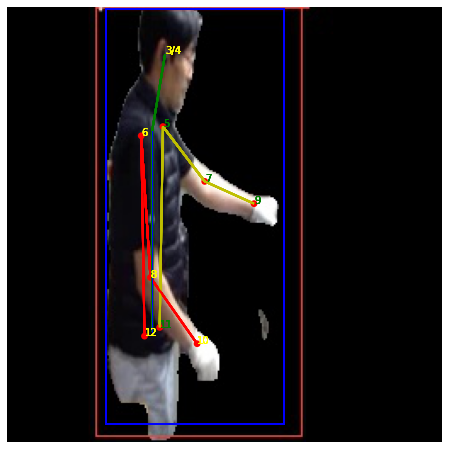

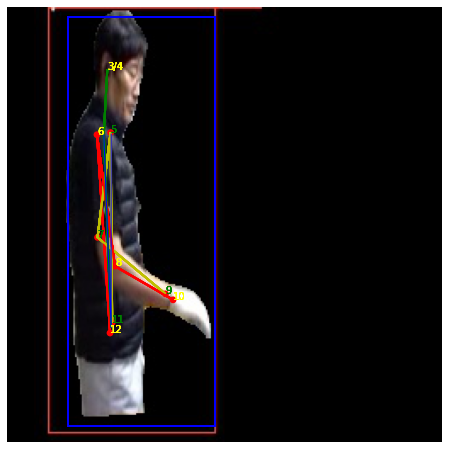

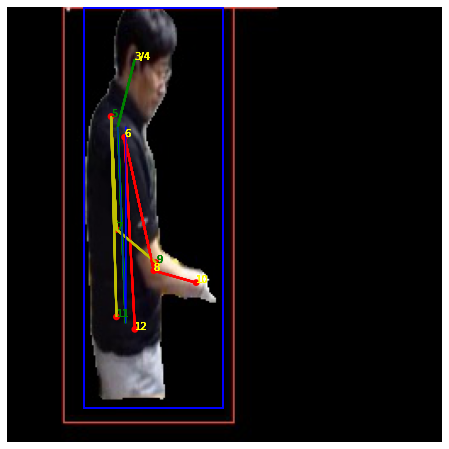

In [6]:
THRESHOLD = 0.95

path = "./img/3_output_bg/"
file_list = os.listdir(path)
print("{}".format(file_list))

# 저장할 엑셀 생성
# 엑셀파일 쓰기
write_wb = Workbook()

# 이름이 있는 시트를 생성
# write_ws = write_wb.create_sheet('Sheet1')

# Sheet1에다 입력
write_ws = write_wb.active

# Skeleton column 생성
write_ws.cell(1,1, '파일명')
write_ws.cell(1,2, 'left_sho')
write_ws.cell(1,3, 'right_sho')
write_ws.cell(1,4, 'left_elbow')
write_ws.cell(1,5, 'right_elbow')
write_ws.cell(1,6, 'left_wrist')
write_ws.cell(1,7, 'right_wrist')
write_ws.cell(1,8, 'left_trunk')
write_ws.cell(1,9, 'right_trunk')
write_ws.cell(1,10, 'head')
write_ws.cell(1,11, 'neck')

# Angle column 생성
write_ws.cell(1,12, 'left_sho_angle')
write_ws.cell(1,13, 'right_sho_angle')
write_ws.cell(1,14, 'left_elbow_angle')
write_ws.cell(1,15, 'right_elbow_angle')
write_ws.cell(1,16, 'neck_angle')
write_ws.cell(1,17, 'trunk_angle')



# 각도 계산
import math
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return abs(ang - 360) if ang > 180 else abs(ang) #+ 360 if ang < 0 else ang


for idx, file in enumerate(file_list):
    
    image = Image.open("./img/3_output_bg/"+file)
    
    t = time.time()
    # Image to Tensor
    trf = T.Compose([
        T.Resize(256),
        T.ToTensor() 
        ])
    input_img = trf(image) 
    out = model([input_img])[0]

    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO
    ]

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    
    
    for box, score, keypoints in zip(out['boxes'], out['scores'], out['keypoints']):
        # 스코어가 95% 이상인 것만 사용
        score = score.detach().numpy() # score(텐서)를 떼어내서 numpy배열로 바꾼다.

        if score < THRESHOLD:
            continue

        box = box.detach().numpy()
        keypoints = keypoints.detach().numpy()[:, :2] # numpy array로 변환하고 2개의 값(x, y)만 저장
        print(type(keypoints))
        print(keypoints)
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect) # matplotlib에 patches를 사용하여 박스를 그려준다.

        # 17 keypoints(표시할 점의 갯수를 조절가능)
        for k in keypoints[5:13]:

            circle = patches.Circle((k[0], k[1]), radius=2, facecolor='r')
            ax.add_patch(circle)
            
            ax.text(keypoints[5][0],keypoints[5][1], '5', color='green')      # [5] 왼쪽 어깨
            ax.text(keypoints[6][0],keypoints[6][1], '6', color='yellow')     # [6] 오른 어깨
            ax.text(keypoints[7][0],keypoints[7][1], '7', color='green')      # [7] 왼쪽 팔꿈치
            ax.text(keypoints[8][0],keypoints[8][1], '8', color='yellow')     # [8] 오른 팔꿈치
            ax.text(keypoints[9][0],keypoints[9][1], '9', color='green')      # [9] 왼쪽 손목
            ax.text(keypoints[10][0],keypoints[10][1], '10', color='yellow')  # [10] 오른 손목
            ax.text(keypoints[11][0],keypoints[11][1], '11', color='green')   # [11] 왼쪽 허리
            ax.text(keypoints[12][0],keypoints[12][1], '12', color='yellow')  # [12] 오른 허리

            head = ((keypoints[3]+keypoints[4])/2)
            ax.text(head[0],head[1], '3/4', color='yellow')

            # Draw line
            # 왼쪽어깨굴곡(6,8,12)
            verts = [keypoints[8],keypoints[6],keypoints[12]]
            path = Path(verts, codes)
            line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
            ax.add_patch(line)


            # 왼쪽팔꿈치굴곡(5,7,9)
            verts = [keypoints[5],keypoints[7],keypoints[9]]
            path = Path(verts, codes)
            line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='y')
            ax.add_patch(line)

            # 오른쪽어깨굴곡(11,5,7)
            verts = [keypoints[11],keypoints[5],keypoints[7]]
            path = Path(verts, codes)
            line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='y')
            ax.add_patch(line)

            # 오른쪽팔꿈치굴곡(6,8,10)
            verts = [keypoints[6],keypoints[8],keypoints[10]]
            path = Path(verts, codes)
            line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
            ax.add_patch(line)

            # 목 굴곡
            verts = [((keypoints[3]+keypoints[4])/2),((keypoints[5]+keypoints[6])/2),((keypoints[11]+keypoints[12])/2)]
            path = Path(verts, codes)
            line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='g')
            ax.add_patch(line)

            # 허리 굴곡
            verts = [((keypoints[5]+keypoints[6])/2), ((keypoints[11]+keypoints[12])/2), (((keypoints[11]+keypoints[12])/2)[0],((keypoints[5]+keypoints[6])/2)[1])]
            path = Path(verts, codes)
            line = patches.PathPatch(path, linewidth=1, facecolor='none', edgecolor='b')
            ax.add_patch(line)
            ax.set_axis_off()
            fig.savefig('./img/4_output_kp/'+file, bbox_inches='tight')
            

    left_sho_angle = (getAngle((keypoints[7]), (keypoints[5]), (keypoints[11])))
    right_sho_angle = (getAngle((keypoints[8]), (keypoints[6]), (keypoints[12])))
    
    left_albow_angle = (getAngle((keypoints[5]), (keypoints[7]), (keypoints[9])))
    right_albow_angle = (getAngle((keypoints[6]), (keypoints[8]), (keypoints[10])))

    
    neck_angle = getAngle(((keypoints[3]+keypoints[4])/2),((keypoints[5]+keypoints[6])/2),((keypoints[11]+keypoints[12])/2))
    if neck_angle > 90 :
        neck_angle = (180 - getAngle(((keypoints[3]+keypoints[4])/2), ((keypoints[5]+keypoints[6])/2), ((keypoints[11]+keypoints[12])/2)))/2
    elif neck_angle >= 45:
        neck_angle = neck_angle/15
    elif neck_angle < 45:
        neck_angle = neck_angle

    trunk_angle = getAngle(((keypoints[5]+keypoints[6])/2), ((keypoints[11]+keypoints[12])/2),(((keypoints[11]+keypoints[12])/2)[0],((keypoints[5]+keypoints[6])/2)[1]))/2

    
    
#     # save as a dictionary format of keypoint, angle
#     keypoint_dict = {'left_sho' : keypoints[5], 
#                  'right_sho' : keypoints[6], 
#                  'left_elbow' : keypoints[7], 
#                  'right_elbow' : keypoints[8],
#                  'left_wrist' : keypoints[9],
#                  'right_wrist' : keypoints[10],
#                  'left_trunk' : keypoints[11],
#                  'rightt_wrist' : keypoints[12],
#                  'head' : head,
#                  'neck' : ((keypoints[3]+keypoints[4])/2)
#                 }

#     angle_dict = {'left_sho_angle' : left_sho_angle,
#                   'right_sho_angle' : right_sho_angle,
#                   'left_elbow_angle' : left_albow_angle,
#                   'right_elbow_angle' : right_albow_angle,
#                   'neck_angle' : neck_angle,
#                   'trunk_angle' : trunk_angle    
#                   }

    idx = idx + 1
    # 엑셀 데이터 입력
    write_ws['A'+str(idx+1)] = file # 파일명 쓰기
    write_ws['B'+str(idx+1)] = left_sho_angle
    
    
    print("작업명 : "+file)
    print("왼쪽 어깨 굴곡 각도       : "+str(round(left_sho_angle, 2))+" 도")
    print("왼쪽 팔꿈치 굴곡 각도     : "+str(round(left_albow_angle, 2))+" 도")
    print("오른쪽 어깨 굴곡 각도     : "+str(round(right_sho_angle, 2))+" 도")
    print("오른쪽 팔꿈치 굴곡 각도   : "+str(round(right_albow_angle, 2))+" 도")
    print("목 굴곡 각도              : "+str(round(neck_angle, 2))+" 도")
    print("허리 굴곡 각도            : "+str(round(trunk_angle, 2))+" 도")


    print('executed in %.3fs' % (time.time() - t))
    
# 엑셀 저장
write_wb.save("keypoints.xlsx")

### RULA calculation

#### Save JC, Angle

In [2]:
!pip install openpyxl

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "C:\Users\KSWLAB_1\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\KSWLAB_1\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\KSWLAB_1\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\KSWLAB_1\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\KSWLAB_1\Anaconda3\lib\site-pack

#### 엑셀 쓰기

In [25]:
from openpyxl import Workbook

#     keypoint_dict = {'left_sho' : keypoints[5], 
#                  'right_sho' : keypoints[6], 
#                  'left_elbow' : keypoints[7], 
#                  'right_elbow' : keypoints[8],
#                  'left_wrist' : keypoints[9],
#                  'right_wrist' : keypoints[10],
#                  'left_trunk' : keypoints[11],
#                  'rightt_wrist' : keypoints[12]
#                  'head' : head
#                  'neck' : (keypoints[3]+keypoints[4])/2
#                 }

#     angle_dict = {'left_sho_angle' : left_sho_angle,
#                   'right_sho_angle' : right_sho_angle,
#                   'left_elbow_angle' : left_albow_angle,
#                   'right_elbow_angle' : right_albow_angle,
#                   'neck_angle' : neck_angle,
#                   'trunk_angle' : trunk_angle    
#                   }

# 엑셀파일 쓰기
write_wb = Workbook()

# 이름이 있는 시트를 생성
# write_ws = write_wb.create_sheet('Sheet1')

# Sheet1에다 입력
write_ws = write_wb.active

# Skeleton column 생성
write_ws.cell(1,2, 'left_sho')
write_ws.cell(1,3, 'right_sho')
write_ws.cell(1,4, 'left_elbow')
write_ws.cell(1,5, 'right_elbow')
write_ws.cell(1,6, 'left_wrist')
write_ws.cell(1,7, 'right_wrist')
write_ws.cell(1,8, 'left_trunk')
write_ws.cell(1,9, 'right_trunk')
write_ws.cell(1,10, 'head')
write_ws.cell(1,11, 'neck')

# Angle column 생성
write_ws.cell(1,12, 'left_sho_angle')
write_ws.cell(1,13, 'right_sho_angle')
write_ws.cell(1,14, 'left_elbow_angle')
write_ws.cell(1,15, 'right_elbow_angle')
write_ws.cell(1,16, 'neck_angle')
write_ws.cell(1,17, 'trunk_angle')

# 데이터 입력
write_ws['A1'] = '숫자'

# 엑셀 저장
write_wb.save("keypoints.xlsx")


#### 엑셀 읽기

In [24]:
from openpyxl import load_workbook

# data_only=True로 해줘야 수식이 아닌 값으로 받아온다. 
load_wb = load_workbook("keypoints.xlsx", data_only=True)

# 시트 이름으로 불러오기 
load_ws = load_wb['Sheet']

# 셀 주소로 값 출력
print(load_ws['B1'].value)

# 셀 좌표로 값 출력
# print(load_ws.cell(1, 3).value)

# 



left_sho


### RULA computation

In [ ]:
def RULA(left_sho_angle,right_sho_angle,left_albow_angle,right_albow_angle,neck_angle):
    if left_sho_angle